In [1]:
%cd ../..

/ibex/user/slimhy/Shape2VecSet/code


In [2]:
"""
Extracting features into HDF5 files for each split.
"""
import argparse
import h5py
import json
import numpy as np
import os
import os.path as osp
import pprint

import torch
import torch.backends.cudnn as cudnn
import warnings

from transformers import AutoTokenizer, CLIPTextModel, BertTokenizer, BertModel

import util.misc as misc
import models.autoencoders as ae_mods
from engine_node2node import get_text_embeddings
from util.datasets import build_shape_surface_occupancy_dataset

from argparse import ArgumentParser
from models.mlp import MLP
from models.point_net import PointNet
from models.pointcloud_autoencoder import PointcloudAutoencoder


def describe_pc_ae(args):
    # Make an AE.
    if args.encoder_net == "pointnet":
        ae_encoder = PointNet(init_feat_dim=3, conv_dims=args.encoder_conv_layers)
        encoder_latent_dim = args.encoder_conv_layers[-1]
    else:
        raise NotImplementedError()

    if args.decoder_net == "mlp":
        ae_decoder = MLP(
            in_feat_dims=encoder_latent_dim,
            out_channels=args.decoder_fc_neurons + [args.n_pc_points * 3],
            b_norm=False,
        )

    model = PointcloudAutoencoder(ae_encoder, ae_decoder)
    return model


def load_state_dicts(checkpoint_file, map_location=None, **kwargs):
    """ Load torch items from saved state_dictionaries"""
    if map_location is None:
        checkpoint = torch.load(checkpoint_file)
    else:
        checkpoint = torch.load(checkpoint_file, map_location=map_location)

    for key, value in kwargs.items():
        value.load_state_dict(checkpoint[key])

    epoch = checkpoint.get('epoch')
    if epoch:
        return epoch


def read_saved_args(config_file, override_or_add_args=None, verbose=False):
    """
    :param config_file: json file containing arguments
    :param override_args: dict e.g., {'gpu': '0'} will set the resulting arg.gpu to be 0
    :param verbose:
    :return:
    """
    parser = ArgumentParser()
    args = parser.parse_args([])
    with open(config_file, "r") as f_in:
        args.__dict__ = json.load(f_in)

    if override_or_add_args is not None:
        for key, val in override_or_add_args.items():
            args.__setattr__(key, val)

    if verbose:
        args_string = pprint.pformat(vars(args))
        print(args_string)

    return args


def load_pretrained_pc_ae(model_file):
    config_file = osp.join(osp.dirname(model_file), "config.json.txt")
    pc_ae_args = read_saved_args(config_file)
    pc_ae = describe_pc_ae(pc_ae_args)

    best_epoch = load_state_dicts(model_file, model=pc_ae)
    print(f"Pretrained PC-AE is loaded at epoch {best_epoch}.")
    return pc_ae, pc_ae_args

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [3]:
def get_args_parser():
    parser = argparse.ArgumentParser("Extracting Features", add_help=False)

    # Model parameters
    parser.add_argument(
        "--batch_size",
        default=32,
        type=int,
        help="Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus",
    )
    parser.add_argument(
        "--text_model_name",
        type=str,
        help="Text model name to use",
    )
    parser.add_argument(
        "--ae",
        type=str,
        metavar="MODEL",
        help="Name of autoencoder",
    )
    parser.add_argument(
        "--ae-latent-dim",
        type=int,
        default=512*8,
        help="AE latent dimension",
    )
    parser.add_argument(
        "--ae_pth",
        required=True,
        help="Autoencoder checkpoint"
    )
    parser.add_argument(
        "--point_cloud_size",
        default=2048,
        type=int,
        help="input size"
    )
    parser.add_argument(
        "--fetch_keys",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--use_embeds",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--get_voxels",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--intensity_loss",
        action="store_true",
        default=False,
        help="Contrastive edit intensity loss using ground-truth labels.",
    )

    # Dataset parameters
    parser.add_argument(
        "--dataset",
        type=str,
        choices=["graphedits"],
        help="dataset name",
    )
    parser.add_argument(
        "--data_path",
        type=str,
        help="dataset path",
    )
    parser.add_argument(
        "--data_type",
        type=str,
        help="dataset type",
    )
    parser.add_argument(
        "--max_edge_level",
        default=None,
        type=int,
        help="maximum edge level to use",
    )
    parser.add_argument(
        "--device", default="cuda", help="device to use for training / testing"
    )
    parser.add_argument("--seed", default=0, type=int)
    parser.add_argument("--num_workers", default=60, type=int)
    parser.add_argument(
        "--pin_mem",
        action="store_true",
        help="Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.",
    )

    return parser

In [4]:
# Set dummy arg string to debug the parser
call_string = """--ae_pth /ibex/user/slimhy/Shape2VecSet/output/pc_ae/best_model.pt \
    --ae-latent-dim 256 \
    --text_model_name bert-base-uncased \
    --dataset graphedits \
    --data_path /ibex/user/slimhy/ShapeWalk/ \
    --data_type release_chained \
    --batch_size 32 \
    --num_workers 8 \
    --point_cloud_size 8192 \
    --device cuda \
    --fetch_keys \
    --seed 0"""

# Parse the arguments
args = get_args_parser()
args = args.parse_args(call_string.split())

In [5]:
# --------------------
args.use_clip = "clip" in args.text_model_name
device = torch.device(args.device)

# Fix the seed for reproducibility
seed = args.seed + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

args.fetch_keys = True

# Defining transformation
if "RND" in args.data_path:
    scale_factor = np.array([0.46350697, 0.35710097, 0.40755142])  # RND
else:
    scale_factor = np.array([0.33408034, 0.39906635, 0.35794342])  # NORMALSHIET

rotate_matrix = np.array(
    [[1, 0, 0], [0, 1, 0], [0, 0, -1]]
)

def center_in_unit_sphere(pc, in_place=True):
    if not in_place:
        pc = pc.copy()
    
    for axis in range(3):  # center around each axis
        r_max = np.max(pc[:, axis])
        r_min = np.min(pc[:, axis])
        gap = (r_max + r_min) / 2.0
        pc[:, axis] -= gap

    largest_distance = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc /= largest_distance
    return pc

# Apply both scaling and rotation
transform = lambda x: center_in_unit_sphere(np.matmul(
    rotate_matrix, x.T
).T) * scale_factor

dataset_train = build_shape_surface_occupancy_dataset("train", args=args, transform=transform)
dataset_val = build_shape_surface_occupancy_dataset("val", args=args, transform=transform)

# Create data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)
# --------------------

# Instantiate autoencoder
print("Loading autoencoder [%s]..." % args.ae_pth)
pc_ae, pc_ae_args = load_pretrained_pc_ae(args.ae_pth)
pc_ae = pc_ae.to(device)
pc_ae = pc_ae.eval()
print("Done.")

print("Loading text model [%s]..." % args.text_model_name)
# Initialize text CLIP model
if args.use_clip:
    # Instantiate tokenizer + CLIP model
    tokenizer = AutoTokenizer.from_pretrained(args.text_model_name)
    text_model = CLIPTextModel.from_pretrained(args.text_model_name).to(device)
else:
    # Instantiate BERT model and create linear projection layer
    tokenizer = BertTokenizer.from_pretrained(args.text_model_name)
    text_model = BertModel.from_pretrained(args.text_model_name).to(device)

text_model = text_model.eval()
print("Done.")

/home/slimhy/conda/envs/shape2vecset/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading autoencoder [/ibex/user/slimhy/Shape2VecSet/output/pc_ae/best_model.pt]...
Pretrained PC-AE is loaded at epoch 186.
Done.
Loading text model [bert-base-uncased]...
Done.


In [6]:
iter_debug = iter(data_loader_train)

Average CD: 0.000194


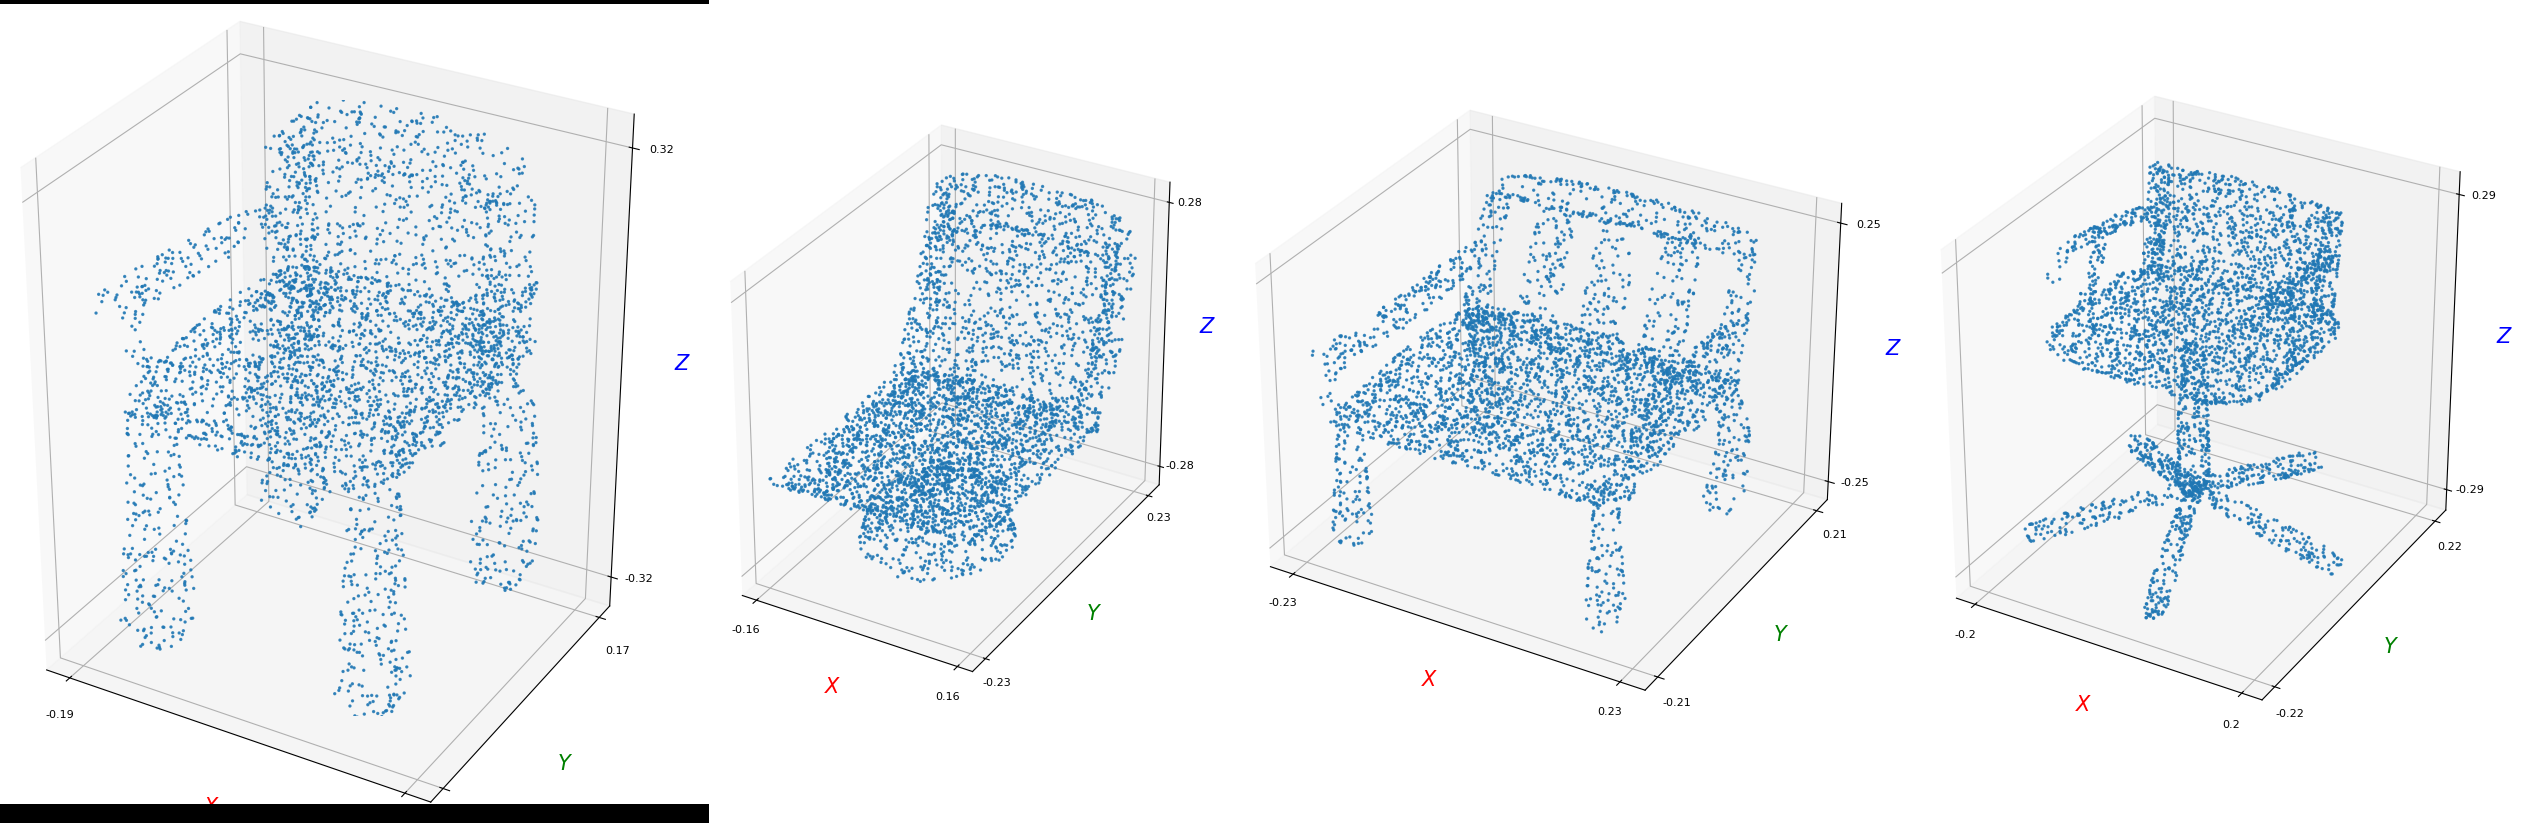

In [7]:
from plot_pc import plot_pointclouds

DEBUG_AE = True
if DEBUG_AE:
    # Safety check: fetch a single batch
    pc_batch = next(iter_debug)
    pc_batch = pc_batch[1]
    pc_batch = pc_batch[:, :4096, :]
    
    # Decode the batch
    pc_rec, _, avg_cd = pc_ae.reconstruct(loader=[{"pointcloud": pc_batch}],
                                          device=device,
                                          loss_rule='chamfer')
    
    # Print average CD
    print("Average CD: %f" % avg_cd)
    
# Visualize 8 reconstructions
plot_pointclouds(np.array(pc_batch[:4]))

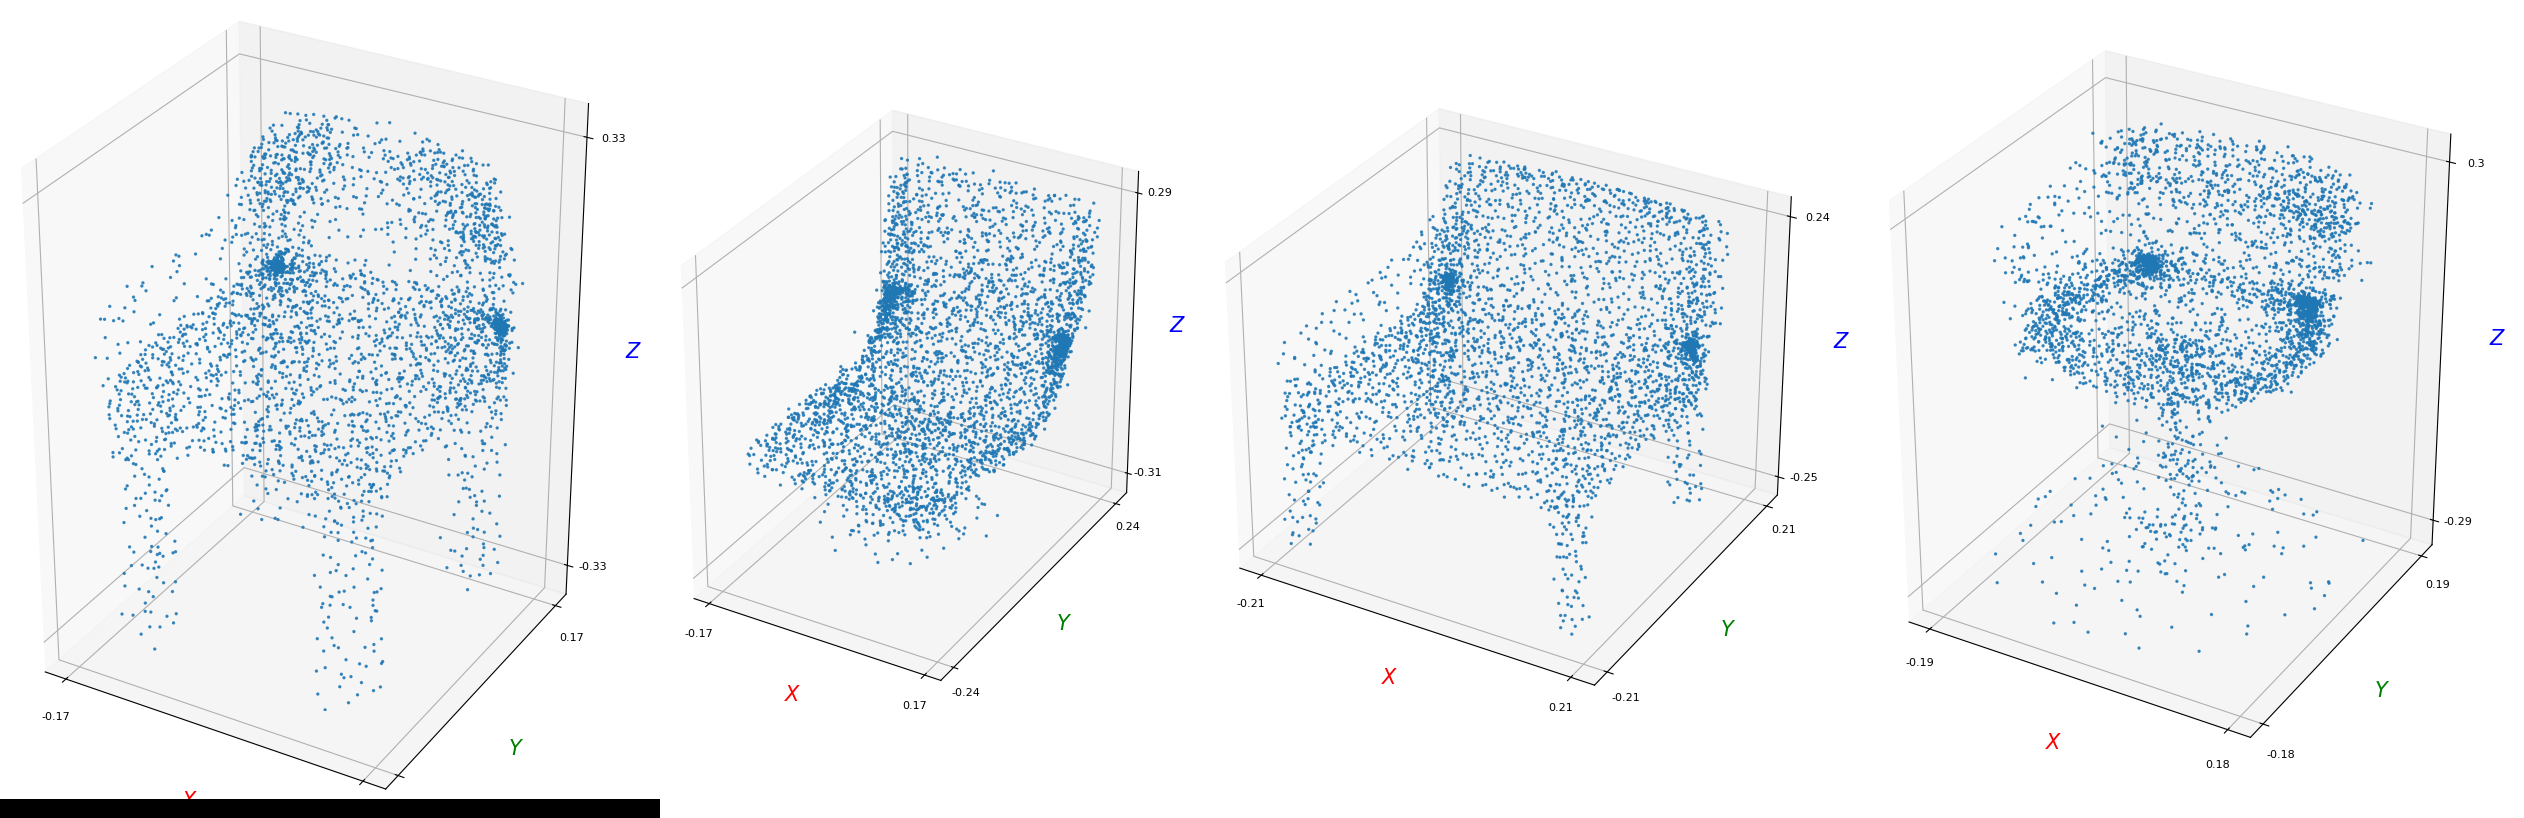

In [8]:
plot_pointclouds(np.array(pc_rec[:4]))

In [9]:
from tqdm.notebook import trange, tqdm

def get_split_embeddings(args, data_loader):
    text_latent_dim = 512 if args.use_clip else 768

    # Create stacked numpy arrays to store embeddings
    B = args.batch_size
    n_batches = len(data_loader)
    n_entries = n_batches * B
    embeds_xa   = np.zeros((n_entries, args.ae_latent_dim))
    embeds_xb   = np.zeros((n_entries, args.ae_latent_dim))
    embeds_text = np.zeros((n_entries, text_latent_dim))
    all_keys = ["_" for _ in range(n_entries)]

    # Iterate over the dataset and extract text embeddings
    for k, (edit_keys, nodes_a, nodes_b, prompts_ab) in enumerate(tqdm(data_loader)):
        nodes_a = nodes_a.to(device, non_blocking=True)
        nodes_b = nodes_b.to(device, non_blocking=True)
        embeds_ab = get_text_embeddings(text_model=text_model,
                                        tokenizer=tokenizer,
                                        texts=prompts_ab,
                                        device=device)

        with torch.no_grad():
            x_a = pc_ae.embed(nodes_a)
            x_b = pc_ae.embed(nodes_b)

        # Move batch to CPU and convert to numpy
        embeds_ab = embeds_ab.cpu().numpy()
        x_a = x_a.cpu().numpy()
        x_b = x_b.cpu().numpy()

        # Store to stacked arrays
        embeds_xa[k*B:(k+1)*B] = x_a.reshape(B, -1)
        embeds_xb[k*B:(k+1)*B] = x_b.reshape(B, -1)
        embeds_text[k*B:(k+1)*B] = embeds_ab.reshape(B, -1)
        all_keys[k*B:(k+1)*B] = edit_keys
    
    return all_keys, embeds_xa, embeds_xb, embeds_text


def extract_embeddings(data_loader):
    """
    Extract embeddings and remap to shape/edit keys.
    """
    # Extract embeddings
    all_keys, embeds_xa, embeds_xb, embeds_text = get_split_embeddings(args, data_loader)

    edit_keys_sp = [k.split('_') for k in all_keys]
    keys_node_a = [k[0] for k in edit_keys_sp]
    keys_node_b = [k[1] for k in edit_keys_sp]
    
    # Map node keys to indices
    node_a_to_idx = {k: i for i, k in enumerate(keys_node_a)}
    node_b_to_idx = {k: i for i, k in enumerate(keys_node_b)}
    all_nodes = list(set(keys_node_a + keys_node_b))
    print("all_nodes=", len(all_nodes))

    # Build a matrix with all the embeddings
    # using the indices
    shape_embeds = np.zeros((len(all_nodes), args.ae_latent_dim))
    k = 0
    key_to_shape_embeds = {}
    for node_key in node_a_to_idx:
        idx = node_a_to_idx[node_key]
        shape_embeds[k] = embeds_xa[idx]
        key_to_shape_embeds[node_key] = k
        k += 1

    # Remove all nodes already added from node_b
    for node_key in (node_b_to_idx.keys() - node_a_to_idx.keys()):
        idx = node_b_to_idx[node_key]
        shape_embeds[k] = embeds_xb[idx]
        key_to_shape_embeds[node_key] = k
        k += 1

    # Double check that everything is correct
    # Iterate on edit_keys
    print("Checking shape embeddings...")
    intersec_nodes = node_a_to_idx.keys() & node_b_to_idx.keys()
    for node_a, node_b in edit_keys_sp:
        assert node_a in key_to_shape_embeds
        assert node_b in key_to_shape_embeds
    
        # Check that embeddings are correct
        idx_a = key_to_shape_embeds[node_a]
        idx_b = key_to_shape_embeds[node_b]
       
        if node_a not in intersec_nodes:
            assert np.allclose(shape_embeds[idx_a], embeds_xa[node_a_to_idx[node_a]])
        if node_b not in intersec_nodes:
            assert np.allclose(shape_embeds[idx_b], embeds_xb[node_b_to_idx[node_b]])
    print("Done!")

    key_pair_to_text_embeds = {key_pair : k for k, key_pair in enumerate(all_keys)}

    # Double check that everything is correct
    # Iterate on edit_keys
    print("Checking text embeddings...")
    for key_pair in all_keys:
        assert key_pair in key_pair_to_text_embeds

    print("Done!")

    return shape_embeds, key_to_shape_embeds, embeds_text, key_pair_to_text_embeds

In [10]:
def create_hdf5(args, split, shape_embeds, key_to_shape_embeds, embeds_text, key_pair_to_text_embeds):
    """
    Create HDF5 file with the embeddings
    """
    # Create HDF5 file
    hdf5_path = os.path.join(args.data_path, args.data_type, "embeddings_%s__pc_ae.hdf5" % split)
    # If exists: delete
    if os.path.exists(hdf5_path):
        os.remove(hdf5_path)
        print("Deleted existing HDF5 file %s" % hdf5_path)
    print("Creating HDF5 file %s" % hdf5_path)
    f = h5py.File(hdf5_path, "w")

    # Create datasets
    f.create_dataset("shape_embeds", data=shape_embeds)
    f.create_dataset("text_embeds", data=embeds_text)
    f.create_dataset("key_to_shape_embeds",
                     data=json.dumps(key_to_shape_embeds),
                     shape=(1,),
                     dtype=h5py.string_dtype(encoding="utf-8"))
    f.create_dataset("key_pair_to_text_embeds",
                     data=json.dumps(key_pair_to_text_embeds),
                     shape=(1,),
                     dtype=h5py.string_dtype(encoding="utf-8"))
    f.close()

    print("Done!")

In [11]:
# shape_embeds_train, key_to_shape_embeds_train, text_embeds_train, key_pair_to_text_embeds_train = extract_embeddings(data_loader_train)

In [12]:
# shape_embeds_train.shape, text_embeds_train.shape

In [13]:
shape_embeds_val, key_to_shape_embeds_val, text_embeds_val, key_pair_to_text_embeds_val = extract_embeddings(data_loader_val)

  0%|          | 0/130 [00:00<?, ?it/s]

/home/slimhy/conda/envs/shape2vecset/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


all_nodes= 4300
Checking shape embeddings...
Done!
Checking text embeddings...
Done!


In [14]:
shape_embeds_val.shape, text_embeds_val.shape

((4300, 256), (4160, 768))

In [15]:
# create_hdf5(args, "train", shape_embeds_train, key_to_shape_embeds_train, text_embeds_train, key_pair_to_text_embeds_train)
create_hdf5(args, "val", shape_embeds_val, key_to_shape_embeds_val, text_embeds_val, key_pair_to_text_embeds_val)

Deleted existing HDF5 file /ibex/user/slimhy/ShapeWalk/release_chained/embeddings_val__pc_ae.hdf5
Creating HDF5 file /ibex/user/slimhy/ShapeWalk/release_chained/embeddings_val__pc_ae.hdf5
Done!
